## Inference

Putting some new DICOM's files on the preprocessing pipeline to make predictions according to this dataflow: 

![](images/flow.png)

In [95]:
## SEED
import os
seed_value = 42
os.environ['PYTHONHASHSEED']=str(seed_value)

## Libraries
import numpy as np
import pandas as pd
import random
import pydicom
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.image import resize, grayscale_to_rgb
from tensorflow.keras.layers import CenterCrop, Resizing

## For using numpy in tensorflow predictions
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

## Set seed for reproducibility and make a function to keep the seeds constant for each loop
def set_seed(seed_value):
    os.environ['PYTHONHASHSEED']=str(seed_value)
    tf.random.set_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)

## Set memory growth for GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for physical_device in physical_devices: 
    tf.config.experimental.set_memory_growth(physical_device, True)

## Ignore warnings
#import warnings
#warnings.filterwarnings("ignore")

## Initial settings

In [96]:
pretrained = 'vgg16'
img_size = (224, 224)
test_dicoms_path = './data/'
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']
model_path = './models/v11_my_model_xray_udacity_Pneumonia.json'
thresh = 0.634
only_open_new_dicom = False

In [97]:
list_already_checked_dicoms = []

# 

def check_dicom(filename): 
    '''This function reads in a .dcm file,
    checks the important fields for our device.
    
    Returns a numpy array'''

    ## Check if the file has already been checked
    ## If it has, return None
    if filename in list_already_checked_dicoms and only_open_new_dicom:
        return None, None
    ## If it hasn't, open the file and check the fields
    else:
        print('Load file {} ...'.format(filename))

        ## Add the file to the list of already checked files
        list_already_checked_dicoms.append(filename)
        ## Open the file
        ds = pydicom.dcmread(filename)       

        ## Check the fields
        if ds.Modality == 'DX' and ds.BodyPartExamined == 'CHEST' and (ds.PatientPosition == 'PA' or ds.PatientPosition == 'AP'):

            ## Return the numpy array of the image and the DICOM file
            img = ds.pixel_array
            return img, ds
        else:
            return None, None


def preprocess_image(img, img_size):
    '''This function takes the numpy array output by check_dicom and 
    runs the appropriate pre-processing needed for our model input

    Returns the pre-processed image and the cropped image for visualization'''

    ## Get the appropriate pre-processing function depending on the model
    if pretrained == 'vgg16':
        preprocessor = vgg16_preprocess_input
    if pretrained == 'resnet':
        preprocessor = resnet_preprocess_input

    ## Pre-process the image, first by converting it to tensor and then dimension (1, 1024, 1024, 3)
    img = grayscale_to_rgb(tf.reshape(img, (1, img.shape[0], img.shape[1], 1)))

    ## Crop the image to the center 800x800 pixels
    img = CenterCrop(800,800)(img)

    ## Resize the image to the appropriate size
    img_cropped = Resizing(img_size[0],img_size[1], interpolation='nearest',crop_to_aspect_ratio=True)(img)
    
    ## Pre-process the image with the VGG16 pre-processing function
    img = preprocessor(img_cropped[0])

    ## Reshape the image to the appropriate dimension (1, 224, 224, 3)
    img = tf.reshape(img, (1, img_size[0], img_size[1], 3))

    return img,img_cropped

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path):
    ''' This function takes the path to the model and returns the model'''
    with open(model_path, 'r') as json_file:
        model_json = json_file.read()
    model = tf.keras.models.model_from_json(model_json)
    return model


def predict_image(model, img, thresh): 
    '''This function takes the pre-processed image and the model 
    and returns the prediction and probability'''

    prob = model.predict(img, verbose=0)
    if prob[0][0] >= thresh:
        return 1, prob
    else:
        return 0, prob

def run_checking(my_model):
    '''This function runs the checking of the dicom files,
    preprocesses the images, predicts the images,
    plot the cropped images with the prediction and probability,
    and returns a dataframe with the results'''

    ## Create a dictionary to store the results
    dict_img = {'id':[],'filename': [], 'prediction': [], 'probability': [], 'finding': [], 'age':[], 'sex':[], 'position':[], 'modality':[], 'body_part':[]}

    ## Create a figure to plot the images
    fig, ax = plt.subplots(1,3, figsize=(15,10))
    ## Loop through the dicom files
    for axis, i in enumerate(test_dicoms):
        ## Set the seed for reproducibility
        set_seed(seed_value)

        ## Get the full path to the file
        full_path = test_dicoms_path + i
        img = np.array([])

        ## Check the dicom file
        img , ds = check_dicom(full_path)
        
        ## If the file is not valid, continue to the next file
        if img is None:
            continue
        
        ## Pre-process the image
        img_proc, img_cropped = preprocess_image(img, img_size)

        ## Predict the image
        pred, prob = predict_image(my_model,img_proc,thresh)

        ## Add the results to the dictionary
        dict_img['id'].append(ds.PatientID)
        dict_img['filename'].append(i)
        dict_img['prediction'].append(pred)
        dict_img['probability'].append(round(prob[0][0], 3))
        dict_img['finding'].append(ds.StudyDescription)
        dict_img['age'].append(int(ds.PatientAge))
        dict_img['sex'].append(ds.PatientSex)
        dict_img['position'].append(ds.PatientPosition)
        dict_img['modality'].append(ds.Modality)
        dict_img['body_part'].append(ds.BodyPartExamined)

        ## Plot the image
        ax[axis].imshow((img_cropped.numpy()[0]*-255).astype(np.uint8))
        ax[axis].axis('off')

        ## Set the title of the image
        if pred == 1:
            ax[axis].set_title('Prediction: Pneumonia' + '\nProbability: ' + str(round(prob[0][0], 3)), color='red')
        else:
            ax[axis].set_title('Prediction: Not Pneumonia' + '\nProbability: ' + str(round(prob[0][0], 3)), color='red')
    ## Create a dataframe from the dictionary
    df = pd.DataFrame(dict_img)

    ## Show the plot
    plt.show()

    ## Return the dataframe
    return df

Load file ./data/test1.dcm ...


2023-02-06 15:56:45.929331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Load file ./data/test2.dcm ...


2023-02-06 15:56:46.192464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Load file ./data/test3.dcm ...
Load file ./data/test4.dcm ...


2023-02-06 15:56:46.405257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Load file ./data/test5.dcm ...
Load file ./data/test6.dcm ...


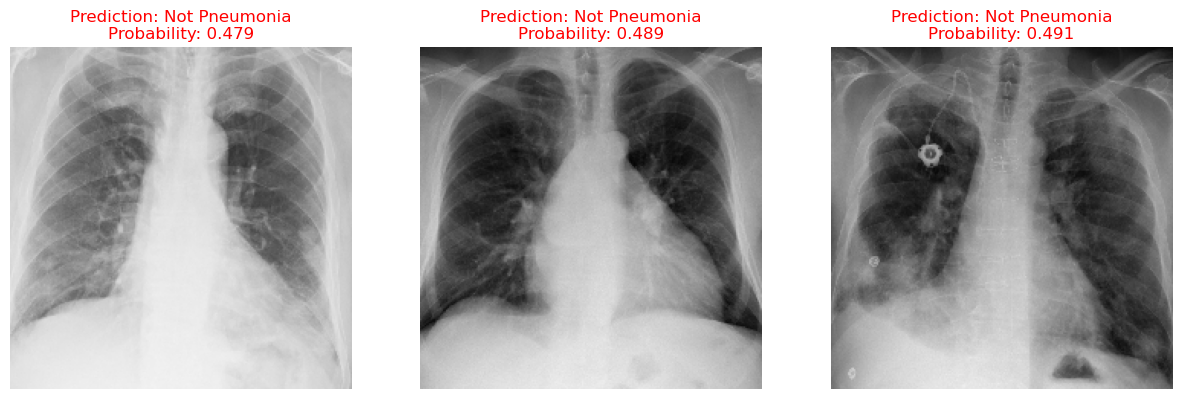

,id,filename,prediction,probability,finding,age,sex,position,modality,body_part
0,2,test1.dcm,0,0.479,No Finding,81,M,PA,DX,CHEST
1,1,test2.dcm,0,0.489,Cardiomegaly,58,M,AP,DX,CHEST
2,61,test3.dcm,0,0.491,Effusion,77,M,AP,DX,CHEST


In [98]:
## Load the model
my_model = load_model(model_path)

## Run the checking
results = run_checking(my_model)

## Show the results of the dataframe
results